###### Author: Ajay Ragh
###### Data Source: https://www.ncmrwf.gov.in/data/
###### Data Required: relative humidity,temperature,presure levels
###### Input Data format: grib2
###### Language: Python3
###### Requirements: numpy,matplotlib,mpl_toolkits,pygrib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygrib 
from mpl_toolkits.mplot3d import Axes3D
import math
import matplotlib.colors as mcolors

In [2]:
relativehumidity = pygrib.open('Data/ncum_imdaa_reanl_HR_RH-prl_2018041912-2018041918.grb2')
temperature = pygrib.open('Data/ncum_imdaa_reanl_HR_TMP-prl_2018041912-2018041918.grb2')

###### Taking required data from the grib2 files and converting them into numpy arrays

In [3]:
heat = []
humid = []
pressure = []
for i in range(24):
    grbtemp = temperature.select()[i]
    grbrh = relativehumidity.select()[i]
    pres = grbtemp.level
    humid.append(grbrh.values)
    heat.append(grbtemp.values)
    pressure.append(pres)
heat = np.array(heat)
humid = np.array(humid)
pressure = np.array(pressure)
lats, lons = grbtemp.latlons()

In [4]:
print(heat.shape)
print(humid.shape)
print(lats.shape)
print(lons.shape)
print(pressure)
pressure.shape
np.savetxt('Outputs/latitudes.txt',lats)
np.savetxt('Outputs/longitudes.txt',lons)

(24, 8, 9)
(24, 8, 9)
(8, 9)
(8, 9)
[  10   20   30   50   70  100  150  200  250  300  400  500  600  700
  750  800  825  850  875  900  925  950  975 1000]


###### Utilising hypsometric equation to convert pressure levels into altitude for reference. 
Note: Hypsometric equation does not provide accurate data above 11km above sea level. 

In [5]:
def hypsometric(pressure,heat):
    height = []
    for i in range(pressure.shape[0]):
        p = pressure[i]
        p0 = 1013.25
        t = np.mean(heat[i])
        h = ((((p0/p)**(1/5.257))-1)*t)/0.0065
        h = h/1000
        height.append(h)
    return height

In [6]:
altitude = hypsometric(pressure,heat)
altitude
np.savetxt('Outputs/altitude.txt',altitude)

###### Functions for the required terms to calculate the refractive index. The equation used here is the equation for radiorefractivity provided by ITU in the document ITU-R P.453-14 (08/2019)

In [7]:
def EF(p,t):
    tc = t-273.15
    ef = 1+(7.2+p*(0.0320+(5.9*10**(-6))*tc**2))
    return ef
def ES(p,t):
    a = 6.1121
    b = 18.678
    c = 257.14
    d = 234.5
    tc = t-273.15
    ef = EF(p,t)
    es = ef*a*math.exp(((b-(tc/d))/(tc+c))*tc)
    return es
def E(h,p,t):
    es = ES(p,t)
    e = (h*es)/100
    return e
def N(h,p,t):
    e = E(h,p,t)
    n = 77.6*(p/t)-5.6*(e/t)+(3.75*10**5)*(e/t**2)
    return n
    

In [8]:
nfield = np.zeros_like(heat)
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        for k in range(heat.shape[2]):
            t = heat[i,j,k]
            p = pressure[i]
            h = humid[i,j,k]
            Ni = N(h,p,t)
            n = 1+(Ni*10**(-6))
            nfield[i,j,k] = n
print(nfield)
for i in range(nfield.shape[0]):
    np.savetxt('Outputs/nfield%01d.txt'%i,nfield[i])

np.save('Outputs/atmospheric_refractive_index_model.npy',nfield)

[[[1.00000334 1.00000334 1.00000334 ... 1.00000334 1.00000334 1.00000334]
  [1.00000334 1.00000334 1.00000334 ... 1.00000334 1.00000334 1.00000334]
  [1.00000334 1.00000334 1.00000334 ... 1.00000334 1.00000334 1.00000334]
  ...
  [1.00000334 1.00000334 1.00000334 ... 1.00000334 1.00000334 1.00000334]
  [1.00000334 1.00000334 1.00000334 ... 1.00000334 1.00000334 1.00000335]
  [1.00000334 1.00000334 1.00000334 ... 1.00000335 1.00000335 1.00000335]]

 [[1.00000686 1.00000686 1.00000686 ... 1.00000685 1.00000685 1.00000685]
  [1.00000686 1.00000686 1.00000686 ... 1.00000685 1.00000685 1.00000685]
  [1.00000685 1.00000685 1.00000685 ... 1.00000685 1.00000685 1.00000685]
  ...
  [1.00000685 1.00000685 1.00000685 ... 1.00000685 1.00000685 1.00000685]
  [1.00000685 1.00000685 1.00000685 ... 1.00000685 1.00000685 1.00000684]
  [1.00000685 1.00000685 1.00000685 ... 1.00000685 1.00000685 1.00000684]]

 [[1.00001049 1.00001049 1.0000105  ... 1.00001052 1.00001052 1.00001052]
  [1.00001048 1.000010

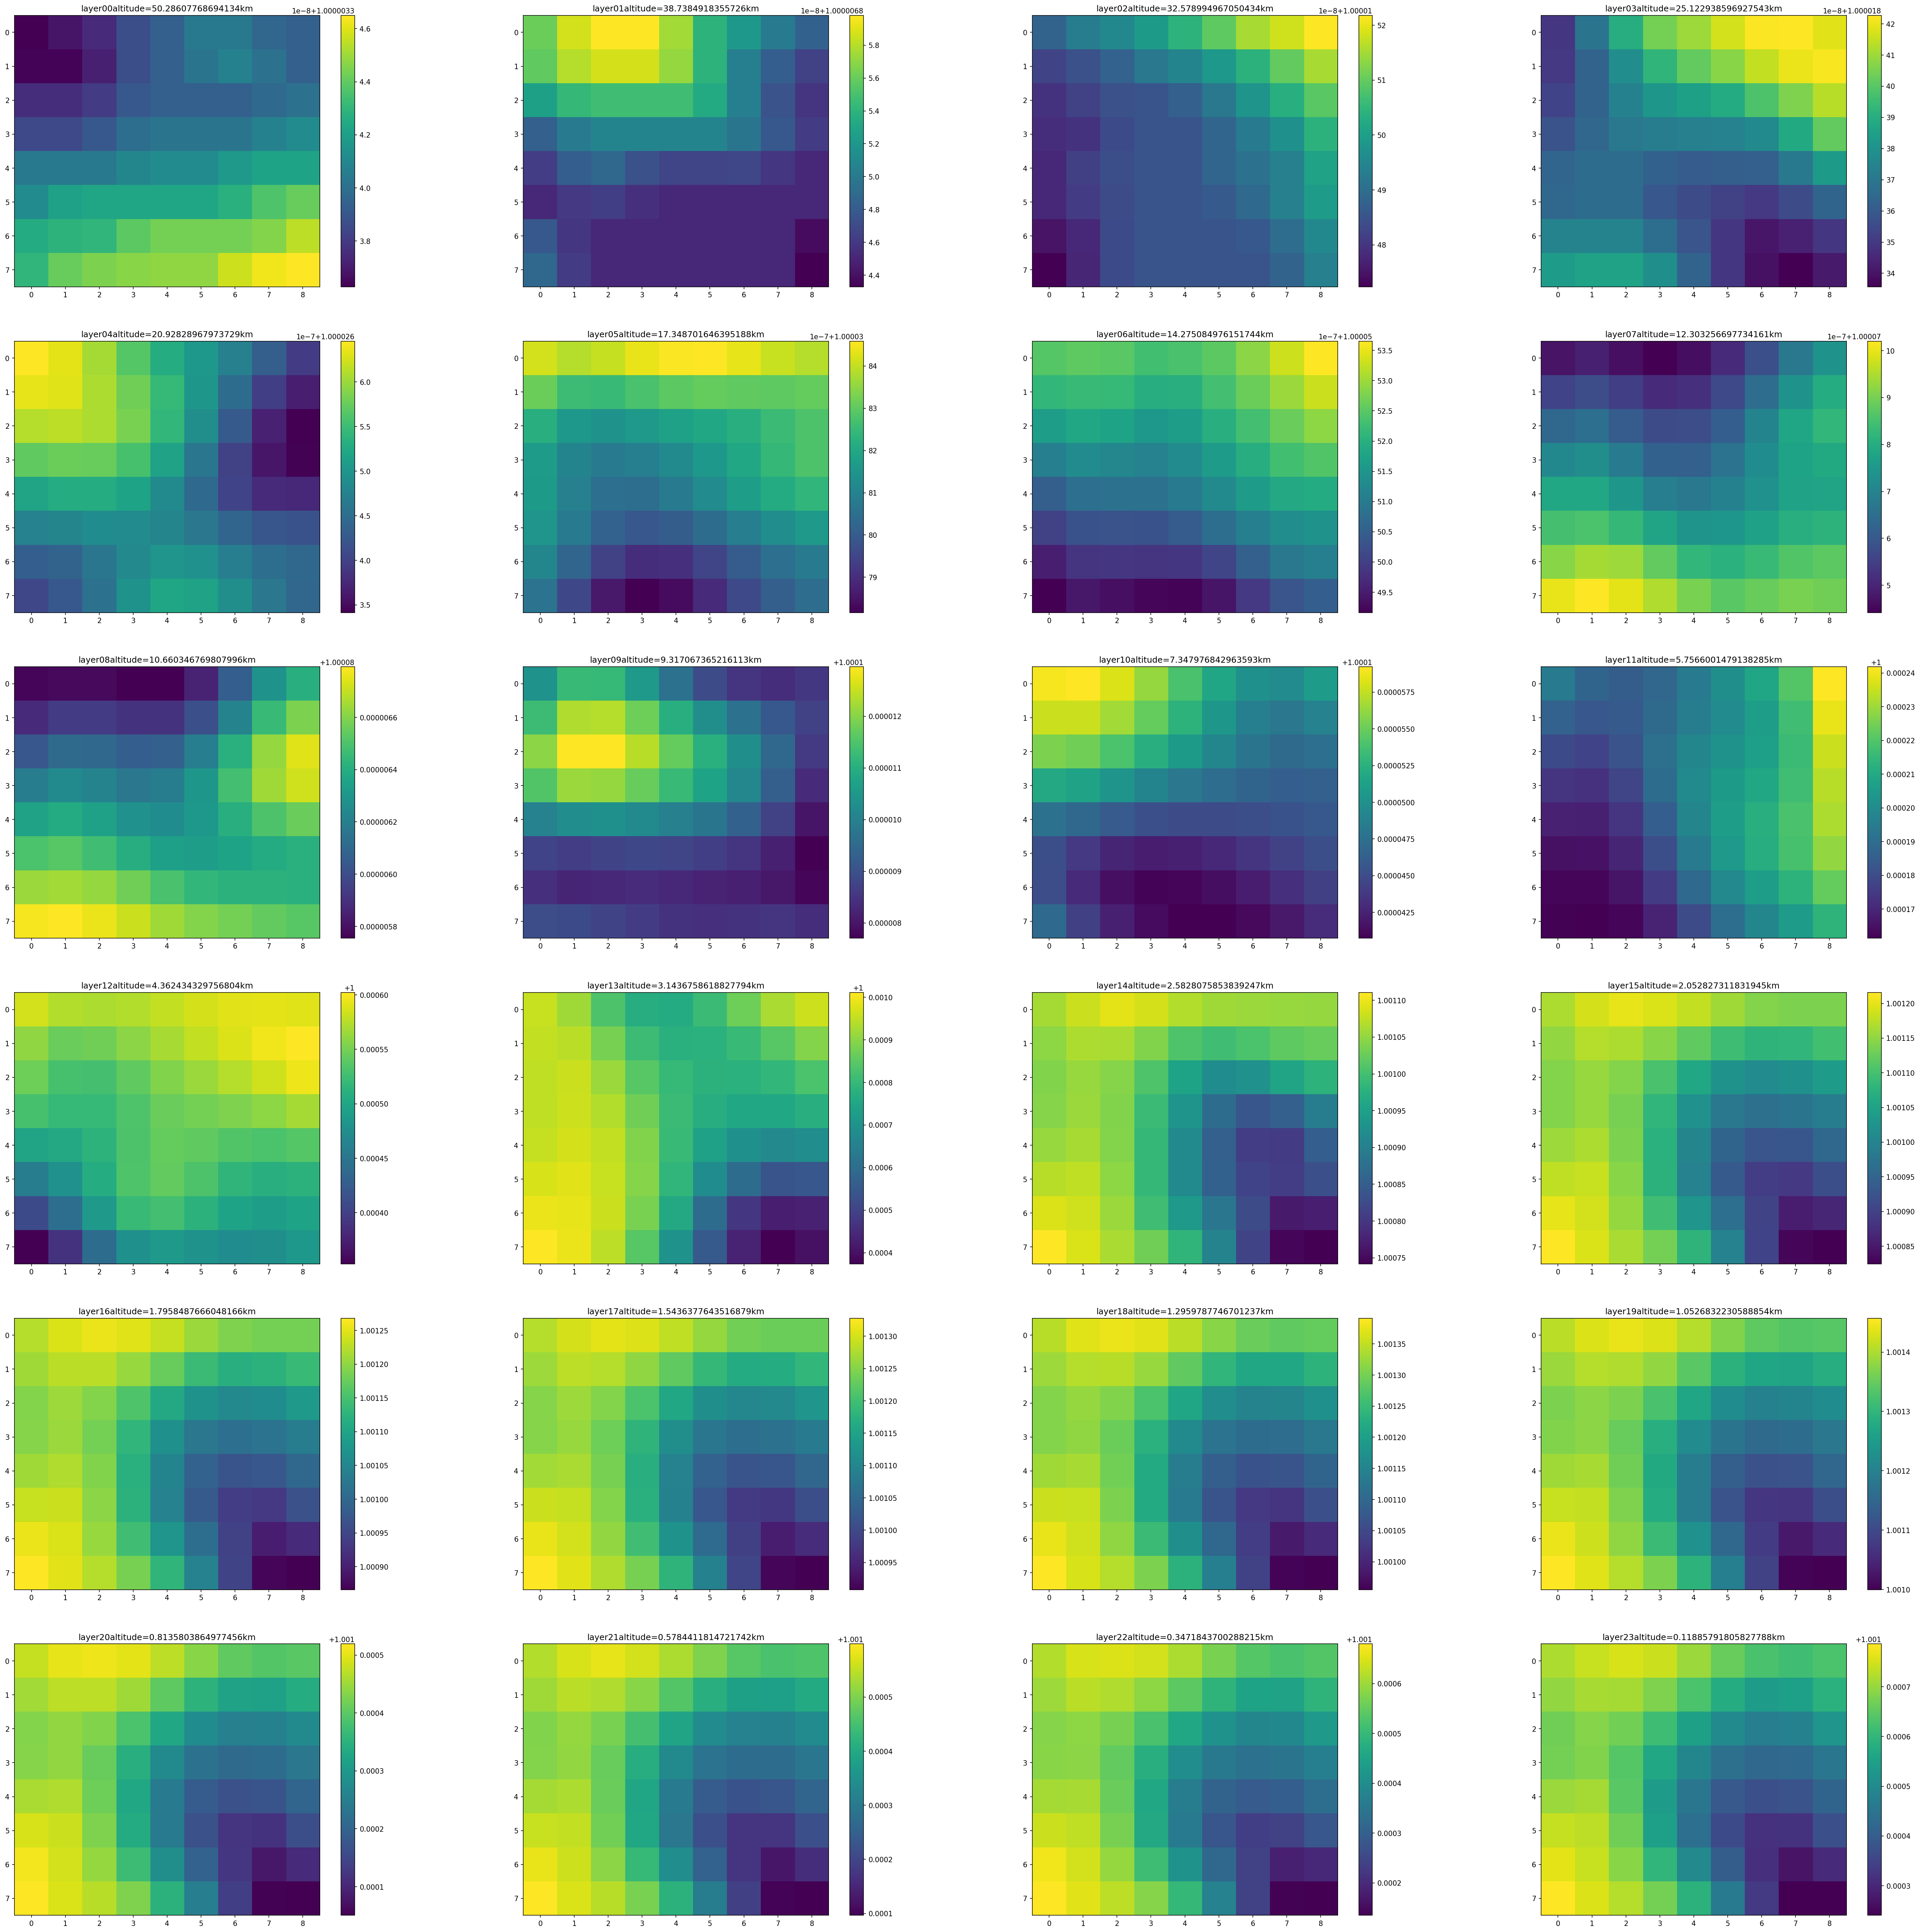

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [50,50]
plt.rcParams['figure.dpi'] = 150

for i in range(nfield.shape[0]):
    plt.subplot(6,4,i+1)
    plt.imshow(nfield[i])
    plt.colorbar()
    plt.title('layer%02d'%i+'altitude='+str(altitude[i])+'km')
    plt.clim(nfield[i].min(),nfield[i].max())
    plt.imsave('Outputs/nfield_layer%02d.png'%i,nfield[i])

In [10]:
print(nfield.max())
print(nfield.min())


1.0017859562425138
1.0000033362711835
